In [14]:
%load_ext autoreload
%autoreload 2
import numpy as np
import simplenn as sn
from simplenn import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Descenso de gradiente

El descenso de gradiente es una técnica de optimización simple pero efectiva para entrenar modelos derivables.

En cada iteración del algoritmo, se calcula la derivada del error respecto a cada uno de los parámetros `δEδp`, actualizan los pesos en la dirección contraria al gradiente. Esta actualización está mediada por el parámetro `α` que indica la tasa de aprendizaje. 

El algoritmo de descenso de gradiente es simple:

```python
for i in range(iteraciones):
    for p in model.parameters()
        # usamos p[:] para modificar los valores de p
        # y no crear una nueva variable
        p[:] = p - α * δEδp(x,y)
```

Este pseudocódigo obvia algunas partes engorrosas. En particular, la iteración sobre los valores de entrada `x` y salida `y` de los ejemplos, en su versión por `batches`, y el cálculo del error y las derivadas `δEδp`. 

La librería `simplenn` cuenta con la clase `BatchedOptimizer` que se encarga de eso, y nos permite implementar un optimizador de forma muy simple creando una subclase de ella, e implementando el método `optimize_batch`, en donde solo tenemos preocuparnos por optimizar el modelo en base a un batch del conjunto de datos. 

Para este ejercicio, hemos creado la clase `StochasticGradientDescent`, que subclasifica a `BatchedOptimizer`. Implemente, entonces, la parte crucial del método `optimize_batch` de `StochasticGradientDescent`, para que actualice los parámetros en base a los los gradientes ya calculados.

Para probar este optimizador, vamos a utilizar un modelo falso y error falso que nos permitan controlar de manera la entrada al optimizador. La flexiblidad de la clase `Model` de `simplenn` permite hacer esto muy fácilmente creando las clases `FakeModel` y `FakeError`, que ignoran realmente sus entradas y salidas, y solo sirven para que `FakeModel` inicialice 2 parámetros con valore 0 y retorne `[-1,1]` como derivada para ellos.

In [26]:
# Fake model with a single parameter array with 2 items
# Parameters always initialized as 0s
# Derivative is always [1,-1]
class FakeModel(sn.model.ModelWithParameters):
    def __init__(self):
        super().__init__()
        self.parameter = np.zeros(2)
        self.register_parameter("parameter", self.parameter)

    def forward(self,x):
        return x
    
    def backward(self,δEδy):
        δEδx = 0
        δEδp = {"parameter":np.array([1,-1])}
        return δEδx,δEδp
    
# Fake error function without parameters
# forward always returns 1
# backward always returns array with same shape as input
# and all values set to 1
class FakeError(sn.ErrorModel):
    def forward(self,y,y_true):
        self.set_cache(y.shape)
        return 1
    def backward(self,δE):
        shape, = self.get_cache()
        return np.ones(shape),{}

# create a fake dataset, which will not be used really
fake_samples = 3
fake_x = np.random.rand(fake_samples,10)
fake_y = np.random.rand(fake_samples,5)

# Initialize fake model and error, 
model = FakeModel()
error = FakeError()

# Optimize for 1 epoch with lr =2
optimizer = sn.StochasticGradientDescent(batch_size=fake_samples,epochs=1,lr=2,shuffle=False)
history = optimizer.optimize(model,fake_x,fake_y,error,verbose=False)
expected_parameters=np.array([-2,2])
utils.check_same(expected_parameters,model.get_parameters()["parameter"])

# Another additional epoch
history = optimizer.optimize(model,fake_x,fake_y,error,verbose=False)
expected_parameters=np.array([-4,4])
utils.check_same(expected_parameters,model.get_parameters()["parameter"])
    
    
# Optimize for 3 epochs more, now with lr=1
optimizer = sn.StochasticGradientDescent(batch_size=fake_samples,epochs=3,lr=1,shuffle=False)
history = optimizer.optimize(model,fake_x,fake_y,error,verbose=False)
expected_parameters=np.array([-7,7])
utils.check_same(expected_parameters,model.get_parameters()["parameter"])    
    

SUCCESS :) Arrays are equal (tolerance 1e-12)
SUCCESS :) Arrays are equal (tolerance 1e-12)
SUCCESS :) Arrays are equal (tolerance 1e-12)


# Entrenamiento de un modelo de Regresión Lineal con Descenso de gradiente

Ahora que tenemos todos los elementos, podemos definir y entrenar nuestro primer modelo `RegresionLineal` para estimar el precio de casas utilizando el conjunto de datos de [Casas de Boston](https://www.kaggle.com/c/boston-housing)

Dataset sizes: (506, 13) (506, 1)


fit:   0%|          | 0/1000 [00:00<?, ?it/s]

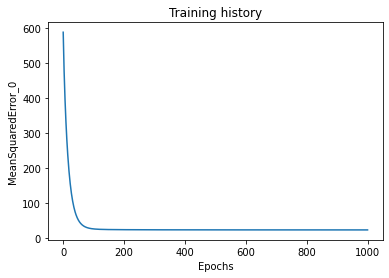

Error del modelo:
RMSE 3.2819156931989593
MAE 3.2819156931989593


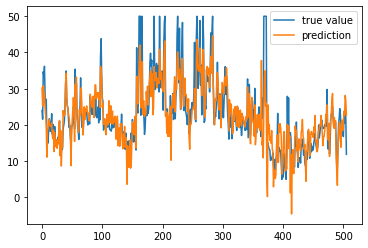

In [24]:
import simplenn as sn
import numpy as np
from simplenn import metrics,datasets

x,y=datasets.load_regression("boston")
x = (x-x.mean(axis=0))/x.std(axis=0)
n, din = x.shape
n, dout = y.shape
print("Dataset sizes:", x.shape,y.shape)

#Red con dos capas lineales
model = sn.LinearRegression(din,dout)
error = sn.MeanError(sn.SquaredError())
optimizer = sn.StochasticGradientDescent(lr=0.001,epochs=1000,batch_size=32)

# Algoritmo de optimización
history = optimizer.optimize(model,x,y,error)
sn.plot.plot_history(history,error_name=error.name)


print("Error del modelo:")
y_pred=model.forward(x)
metrics.regression_summary(y,y_pred)
sn.plot.regression1d_predictions(y,y_pred)

# Comparación con sklearn

Como verificación adicional, calcularemos los parámetros óptimos de un modelo de regresión lineal con sklearn, y visualizamos los resultados. El error debería ser similar al de nuestro modelo (RMSE=3.27 o 3.28).

Error del modelo:
RMSE 3.2708628109003155
MAE 3.2708628109003155



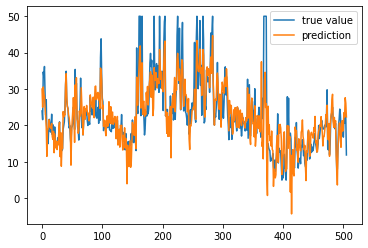

In [25]:
from sklearn import linear_model
model=linear_model.LinearRegression()
model.fit(x,y)
y_pred=model.predict(x)
print("Error del modelo:")
metrics.regression_summary(y,y_pred)
print()

sn.plot.regression1d_predictions(y,y_pred)
